# Plot Images (with Data Augmentation) with Object Bounding Boxes

## Preparations

### Import modules

In [1]:
import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
#from model import Yolov1
from backbone import resnet50, googlenet, vgg16
from dataset import VOCDataset
from pathlib import Path
from utils import (
    non_max_suppression,
    mean_average_precision,
    intersection_over_union,
    cellboxes_to_boxes,
    get_bboxes,
    plot_image,
    save_checkpoint,
    load_checkpoint,
)
import time
import utils
from loss import YoloLoss
import datatrans

seed = 6666
torch.manual_seed(seed)

### Parameters

In [2]:
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
BATCH_SIZE = 16

NUM_WORKERS = 1
PIN_MEMORY = True
IN_DRIVE = True
LOAD_MODEL_FILE = "yolov1.pth"
IMG_DIR = "data/images"
LABEL_DIR = "data/labels"

## Define Transforms

In [3]:
transform = datatrans.Compose([
    datatrans.Resize((448,448)),
    datatrans.RandomAffine(
        translate=(0.2,0.2),
        scale=(0.8,1.2)
    ),
    datatrans.RandomHorizontalFlip(p=0.5),
    datatrans.ColorJitter(
        brightness=0.5,
        saturation=0.5
    ),
    datatrans.ToTensor()
])

transform_test = datatrans.Compose([
    datatrans.Resize((448,448)),
    datatrans.ToTensor()
])

## Define Dataloader and Load Model

In [4]:
model = resnet50(split_size=7, num_boxes=2, num_classes=20, pretrained = False).to(DEVICE)

#optimizer = torch.optim.SGD(model.parameters(), lr=init_lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
loss_fn = YoloLoss()

model.load_state_dict(torch.load(LOAD_MODEL_FILE))

# train_dataset = VOCDataset(
#     "/data/train.csv",
#     transform=transform,
#     img_dir=IMG_DIR,
#     label_dir=LABEL_DIR)

val_dataset = VOCDataset(
    "data/test.csv", 
    transform=transform, 
    img_dir=IMG_DIR, 
    label_dir=LABEL_DIR)

# train_loader = DataLoader(
#     dataset=train_dataset,
#     batch_size=BATCH_SIZE,
#     num_workers=NUM_WORKERS,
#     pin_memory=PIN_MEMORY,
#     shuffle=True,
#     drop_last=True,
# )

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
    drop_last=True,
)

## Get Some Image!

Inference FPS: 5.361312653063833
Loading+inference FPS: 2.8767714456203404


e:\PyCodes\Yolo_v1-Pytorch\utils.py:249: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  color='w'


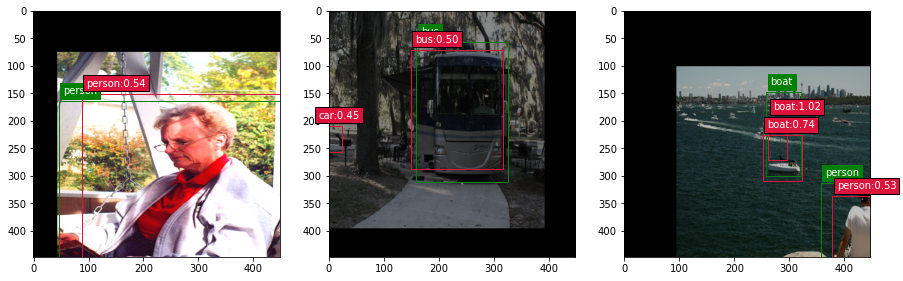

In [5]:
start = time.time()
(pred_bboxes,true_bboxes,x) = utils.get_batch_bboxes(
    loader=val_loader,
    model=model,
    iou_threshold=0.5,
    threshold=0.4,
    device="cuda",
    pred=True
)
end = time.time()
print(f"Loading+inference FPS: {BATCH_SIZE/(end-start)}")
#true_bboxes specified as
#   batch -> idx_box -> 
#   predicted_class, best_confidence, converted_boxes 
#   0,              1,              2:

utils.plot_image(
    x,
    boxes_pred=pred_bboxes,
    boxes_true=true_bboxes,
    nimgs=3
)